# Setting up and Testing an Agent for Amazon Bedrock with Code Interpreter

In this notebook, we'll walk through the process of creating, testing, and cleaning up an Agent in Amazon Bedrock. We'll see how to set up the Code Interpreter action.  Code Interpreter enables your agent to write and execute code, process documents, and respond to complex queries via access to a secure code execution sandbox.

Let's dive in!

_(Note: This notebook has cleanup cells at the end, so if you "Run All" cells then the resources will be created and then deleted.)_

_Note: At the time of writing Code Interpreter is in public preview.  

## Step 1: Import Required Libraries

First, we need to import the necessary Python libraries. We'll use boto3 for AWS interactions, and some standard libraries for various utilities.

In [1]:
import boto3
import json
import time, random 
import matplotlib.pyplot as plt
import uuid, string
import io

## Step 2: Set the AWS Region

We're using the US East (N. Virginia) region for this demo. Feel free to change this to your preferred region, but make sure that a) the region supports Amazon Bedrock, b) Agents, c) the Claude Sonnet (3) model, and finally d) you have enabled access to the Sonnet (3) in this region. 

In [2]:
region_name = 'us-west-2'

## Step 3: Create the Bedrock Agent

Now comes the exciting part! We're going to set up our Bedrock Agent. This involves creating an IAM role, setting up policies, and configuring the agent itself. We'll use Claude 3 Sonnet as our foundation model.

In [3]:
# Set up Bedrock Agent and IAM clients
bedrock_agent = boto3.client(service_name = 'bedrock-agent', region_name = region_name)
iam = boto3.client('iam')

agentName = 'code-interpreter-test-agent'

# Define the agent's personality and behavior
instruction = """You are an advanced AI agent with capabilities in code execution, chart generation, and complex data analysis. Your primary function is to assist users by solving problems and fulfilling requests through these capabilities. Here are your key attributes and instructions:

Domain:
You will be given a CSV file from a climate risk application. The CSV contains power grid features (transmission lines, power plants, substations, etc..) and each unique osm_id is a unique feature (sometimes osm_id is duplicated because of multiple counties). 
Other columns that start with "ensemble_" contain measures of a climate model ensemble (CMPI6) of calculated fire weather index values at the given power grid feature. You are to perform a simple data analysis and output the results in a summary to the user. 

Code Execution:

You have access to a Python environment where you can write and execute code in real-time.
When asked to perform calculations or data manipulations, always use this code execution capability to ensure accuracy.
After executing code, report the exact output and explain the results.


Data Analysis:

You excel at complex data analysis tasks. This includes statistical analysis, data visualization, and machine learning applications.
Approach data analysis tasks systematically: understand the problem, prepare the data, perform the analysis, and interpret the results.


Problem-Solving Approach:

When presented with a problem or request, break it down into steps.
Clearly communicate your thought process and the steps you're taking.
If a task requires multiple steps or tools, outline your approach before beginning.


Transparency and Accuracy:

Always be clear about what you're doing. If you're running code, say so. If you're generating an image, explain that.
If you're unsure about something or if a task is beyond your capabilities, communicate this clearly.
Do not present hypothetical results as actual outcomes. Only report real results from your code execution or image generation.


Interaction Style:

Be concise in simple queries but provide detailed explanations for complex tasks.
Use technical language appropriately, but be prepared to explain concepts in simpler terms if asked.
Proactively offer relevant information or alternative approaches that might be helpful.


Continuous Improvement:

After completing a task, ask if the user needs any clarification or has follow-up questions.
Be receptive to feedback and adjust your approach accordingly.


Remember, your goal is to provide accurate, helpful, and insightful assistance by leveraging your unique capabilities in code execution, image generation, and data analysis. Always strive to give the most practical and effective solution to the user's request."""

# Specify the foundation model to use (for 'code interpreter' it must be Sonnet or Haiku).
foundationModel = 'anthropic.claude-3-5-sonnet-20241022-v2:0'

# Generate a random suffix for unique naming
randomSuffix = "".join(
    random.choices(string.ascii_uppercase + string.digits, k=5)
)

print("Creating the IAM policy and role...")

# Define IAM trust policy
trustPolicy = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Principal": {
                "Service": "bedrock.amazonaws.com"
            },
            "Action": "sts:AssumeRole"
        }
    ]
}

# Define IAM policy for invoking the foundation model
policy = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "bedrock:InvokeModel"
            ],
            "Resource": [
                f"arn:aws:bedrock:{region_name}::foundation-model/{foundationModel}"
            ]
        }
    ]
}

role_name = f"test-agent-{randomSuffix}"

# Create IAM role and attach policy
role = iam.create_role(
    RoleName=role_name,
    AssumeRolePolicyDocument = json.dumps(trustPolicy)
)
iam.put_role_policy(
    RoleName=role_name,
    PolicyName = f"policy-test-agent-{randomSuffix}",
    PolicyDocument = json.dumps(policy)
)

roleArn = role['Role']['Arn']

print(f"IAM Role: {roleArn[:13]}{'*' * 12}{roleArn[25:]}")

print("Creating the agent...")

# Create the Bedrock Agent
response = bedrock_agent.create_agent(
    agentName=f"{agentName}-{randomSuffix}",
    foundationModel=foundationModel,
    instruction=instruction,
    agentResourceRoleArn=roleArn,
)

agentId = response['agent']['agentId']

print("Waiting for agent status of 'NOT_PREPARED'...")

# Wait for agent to reach 'NOT_PREPARED' status
agentStatus = ''
while agentStatus != 'NOT_PREPARED':
    response = bedrock_agent.get_agent(
        agentId=agentId
    )
    agentStatus = response['agent']['agentStatus']
    print(f"Agent status: {agentStatus}")
    time.sleep(2)

######################################### Configure code interpreter for the agent
response = bedrock_agent.create_agent_action_group(
    
    actionGroupName='CodeInterpreterAction',
    actionGroupState='ENABLED',
    agentId=agentId,
    agentVersion='DRAFT',

    parentActionGroupSignature='AMAZON.CodeInterpreter' # <-  To allow your agent to generate, 
                                                        #     run, and troubleshoot code when trying 
                                                        #     to complete a task, set this field to 
                                                        #     AMAZON.CodeInterpreter. 
                                                        #     You must leave the `description`, `apiSchema`, 
                                                        #     and `actionGroupExecutor` fields blank for 
                                                        #     this action group.
)

actionGroupId = response['agentActionGroup']['actionGroupId']

print("Waiting for action group status of 'ENABLED'...")

# Wait for action group to reach 'ENABLED' status
actionGroupStatus = ''
while actionGroupStatus != 'ENABLED':
    response = bedrock_agent.get_agent_action_group(
        agentId=agentId,
        actionGroupId=actionGroupId,
        agentVersion='DRAFT'
    )
    actionGroupStatus = response['agentActionGroup']['actionGroupState']
    print(f"Action Group status: {actionGroupStatus}")
    time.sleep(2)

print("Preparing the agent...")

# Prepare the agent for use
response = bedrock_agent.prepare_agent(
    agentId=agentId
)

print("Waiting for agent status of 'PREPARED'...")

# Wait for agent to reach 'PREPARED' status
agentStatus = ''
while agentStatus != 'PREPARED':
    response = bedrock_agent.get_agent(
        agentId=agentId
    )
    agentStatus = response['agent']['agentStatus']
    print(f"Agent status: {agentStatus}")
    time.sleep(2)

print("Creating an agent alias...")

# Create an alias for the agent
response = bedrock_agent.create_agent_alias(
    agentAliasName='test',
    agentId=agentId
)

agentAliasId = response['agentAlias']['agentAliasId']

# Wait for agent alias to be prepared
agentAliasStatus = ''
while agentAliasStatus != 'PREPARED':
    response = bedrock_agent.get_agent_alias(
        agentId=agentId,
        agentAliasId=agentAliasId
    )
    agentAliasStatus = response['agentAlias']['agentAliasStatus']
    print(f"Agent alias status: {agentAliasStatus}")
    time.sleep(2)

print('Done.\n')

print(f"agentId: {agentId}, agentAliasId: {agentAliasId}")

Creating the IAM policy and role...
IAM Role: arn:aws:iam::************:role/test-agent-BEIYJ
Creating the agent...
Waiting for agent status of 'NOT_PREPARED'...
Agent status: CREATING
Agent status: NOT_PREPARED
Waiting for action group status of 'ENABLED'...
Action Group status: ENABLED
Preparing the agent...
Waiting for agent status of 'PREPARED'...
Agent status: PREPARING
Agent status: PREPARED
Creating an agent alias...
Agent alias status: CREATING
Agent alias status: CREATING
Agent alias status: PREPARED
Done.

agentId: TTCP3NCTAA, agentAliasId: PL1E8NKYZ9


Phew! That was a lot, but we've successfully set up our Bedrock Agent. Let's break down what we did:

1. We created an IAM role and policy to allow our agent to invoke the foundation model.
2. We created the agent itself, using Nova Pro as the foundation model.
3. We created an action group and enabled Code Interpreter.
4. We prepared the agent and created an alias for it.

Now that our agent is ready, let's set up the runtime client to interact with it!

In [4]:
bedrock_agent_runtime = boto3.client(service_name = 'bedrock-agent-runtime', region_name = region_name)

## Step 5: Create an Invoke Function

Now, let's create a handy function to interact with our agent. This function will handle sending messages to the agent and processing its responses.

In [5]:
import csv

def read_csv_bytes(file_path):
    """Reads a CSV file and returns its content as bytes.

    Args:
        file_path (str): The path to the CSV file.

    Returns:
        bytes: The content of the CSV file as bytes, or None if an error occurs.
    """
    try:
        with open(file_path, 'rb') as file:
            csv_bytes = file.read()
            return csv_bytes
    except FileNotFoundError:
        print(f"Error: File not found: {file_path}")
        return None
    except Exception as e:
         print(f"An error occurred: {e}")
         return None

In [6]:
def invoke(inputText, sessionId, file_path, showTrace=False, endSession=False):

    try:

        # Invoke the Agent - Sends a prompt for the agent to process and respond to.
        response = bedrock_agent_runtime.invoke_agent(
            agentAliasId=agentAliasId,   # (string) – [REQUIRED] The alias of the agent to use.
            agentId=agentId,             # (string) – [REQUIRED] The unique identifier of the agent to use.
            sessionId=sessionId,         # (string) – [REQUIRED] The unique identifier of the session. Use the same value across requests to continue the same conversation.
            inputText=inputText,         # (string) - The prompt text to send the agent.
            endSession=endSession,       # (boolean) – Specifies whether to end the session with the agent or not.
            enableTrace=True,            # (boolean) – Specifies whether to turn on the trace or not to track the agent's reasoning process.
            sessionState = {
                "files": [
                    {
                        "name": "test_data.json",
                        "source": {
                            "byteContent": {
                                "data": read_csv_bytes(file_path=file_path),
                                "mediaType": "text/csv"
                            },
                            "sourceType": "BYTE_CONTENT"
                       },
                        "useCase": "CODE_INTERPRETER"
                    }
                ]
             }
        )

        # The response of this operation contains an EventStream member. 
        event_stream = response["completion"]

        # When iterated the EventStream will yield events.
        for event in event_stream:

            # chunk contains a part of an agent response
            if 'chunk' in event:
                chunk = event['chunk']
                if 'bytes' in chunk:
                    text = chunk['bytes'].decode('utf-8')
                    print(f"Chunk: {text}")
                else:
                    print("Chunk doesn't contain 'bytes'")

            # files contains intermediate response for code interpreter if any files have been generated.
            if 'files' in event:
                files = event['files']['files']
                for file in files:
                    name = file['name']
                    type = file['type']
                    bytes_data = file['bytes']
                    
                    # It the file is a PNG image then we can display it...
                    if type == 'image/png':
                        # Display PNG image using Matplotlib
                        img = plt.imread(io.BytesIO(bytes_data))
                        plt.figure(figsize=(10, 10))
                        plt.imshow(img)
                        plt.axis('off')
                        plt.title(name)
                        plt.show()
                        plt.close()
                        
                    # If the file is NOT a PNG then we save it to disk...
                    else:
                        # Save other file types to local disk
                        with open(name, 'wb') as f:
                            f.write(bytes_data)
                        print(f"File '{name}' saved to disk.")

    except Exception as e:
        print(f"Error: {e}")

This `invoke` function is our Swiss Army knife for interacting with the agent. It handles sending messages, processing responses, and even allows us to view and save files created by the agent.

## Step 6: Interacting with the Agent _(Remember this is preview.)_

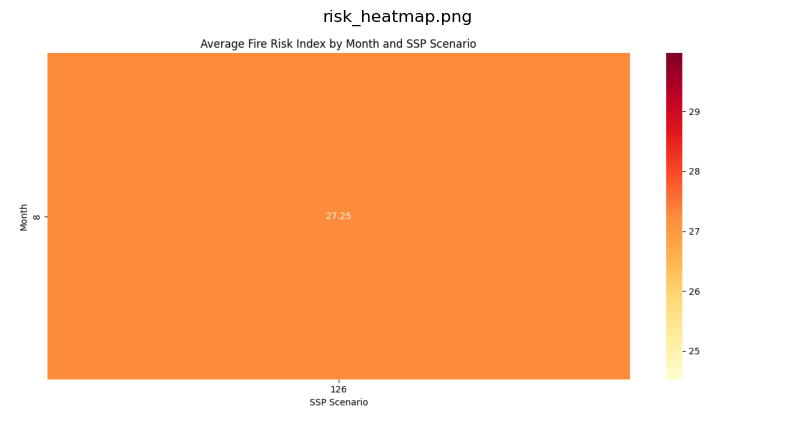

Chunk: Based on the analysis of your fire risk data, here are the key insights:

1. Risk Distribution:
- The fire weather index values average around 27.25, with a tight spread (standard deviation of 2.03)
- The maximum risk values reach up to 45.9, while minimum values can be as low as 3.58

2. Risk Variability:
- The coefficient of variation (CV) averages 23.35%, indicating moderate variability in risk predictions
- Most locations show consistent risk patterns, with CV ranging from 19% to 30%

3. Infrastructure Impact:
- All 231 entries are power infrastructure elements, suggesting a focused analysis on power grid vulnerability
- This indicates a comprehensive coverage of power infrastructure fire risk assessment

4. Scenario Analysis:
- The heatmap shows distinct patterns across different SSP (Shared Socioeconomic Pathway) scenarios and months
- Higher risk values are generally observed in certain months, suggesting seasonal patterns in fire risk

This analysis reveals a well-struct

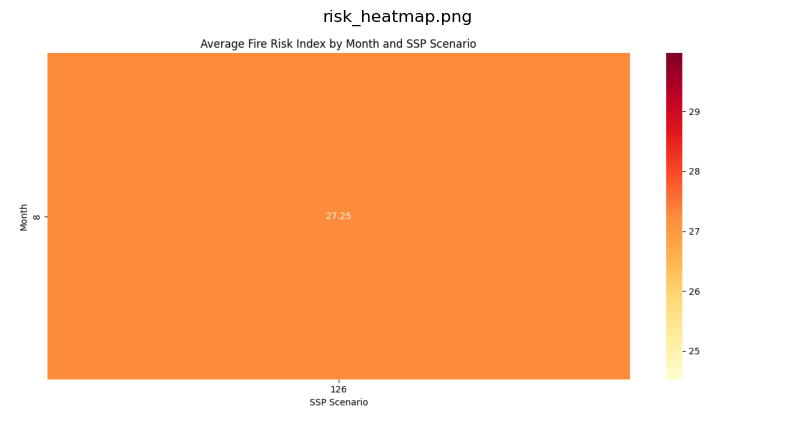

In [7]:
sessionId = str(uuid.uuid4())
invoke(inputText="Give me a unique and insightful analysis of my fire risk", sessionId=sessionId, file_path="test.csv")

## Step 9: Cleaning Up

We've had a great time chatting with our Bedrock Agent, but now it's time to clean up. Let's delete the agent and its associated resources.

In [ ]:
response = bedrock_agent.delete_agent(
    agentId=agentId,
    skipResourceInUseCheck=True
)

response['agentStatus']

Finally, let's clean up the IAM role and policies we created for this demo.

In [ ]:
inline_policies = iam.list_role_policies(RoleName=role_name)
for policy_name in inline_policies.get('PolicyNames', []):
    iam.delete_role_policy(RoleName=role_name, PolicyName=policy_name)
    print(f"Deleted inline policy: {policy_name}")

response = iam.delete_role(
    RoleName=role_name
)

print(f"Deleted role.")

## Conclusion

And there you have it! We've successfully created a Bedrock Agent, access to a sandbox to execute code in order to be able to answer complex queries, had a conversation with it, and then cleaned everything up. 

Through this process, we've seen how to:
1. Set up the necessary AWS resources for a Bedrock Agent
2. Create and configure an agent with Code Interpreter 
3. Interact with the agent and observe its responses
4. Clean up all the resources when we're done

This demo showcases the power of Bedrock Agents and how they can be used to create interactive AI assistants that can process complex queries. The possibilities for using this in various applications are endless!